In [ ]:
import pandas as pd
from google.colab import files
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [ ]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/staticData.csv', names=['x1', 'y1','z1','x2', 'y2','z2','x1_rotacion','y1_rotacion','z1_rotacion','x2_rotacion','y2_rotacion','z2_rotacion', 'direccion','velocidad'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
label_encoder = LabelEncoder()
df['direccion'] = label_encoder.fit_transform(df['direccion'])

In [ ]:
data = df[['x1', 'y1','z1','x2', 'y2','z2','x1_rotacion','y1_rotacion','z1_rotacion','x2_rotacion','y2_rotacion','z2_rotacion']].values

In [ ]:
# Separar las salidas: dirección (categorías) y velocidad (continuo)
#para los datos sin normalizar
y_direction = df['direccion'].values
y_speed = df['velocidad'].values

In [ ]:
#Para normalizar los datos de la velocidad
# Separar las salidas: dirección (categorías) y velocidad (continuo)
y_direction = df['direccion'].values  # Columna con etiquetas de dirección

scaler = MinMaxScaler(feature_range=(-1, 1))
df['velocidad_normalizada'] = scaler.fit_transform(df[['velocidad']])

y_speed = df['velocidad_normalizada'].values     # Columna con valores de velocidad


In [ ]:
#Adaptar el conjunto de datos de entrada a un formato compatible con un modelo de red convolucional que espera imágenes de entrada

#Convierte los datos planos de entrada en una representación de 4 dimensiones con un único canal. Entrada (n, 12) y salida (3 filas x 4 columnas x 1 canal)
x_image = data.reshape(-1, 3, 4, 1)

#Cambia el tamaño de las imágenes de (3x4) a (32x32) usando interpolación. Entrada (n,3,4,1), salida (n,32,32,1). El objetivo es ajustar el tamaño a 32 x 32 que es el tamaño mínimo requerido por ResNet
X_resized = tf.image.resize(x_image, [32, 32])

#Convertir el tensor de TensorFlow a Numpy para las siguientes operaciones
X_resized_np = X_resized.numpy()

#Duplica los datos de canal que existe para crear 3 canales (RGB). Entrada (n,32,32,1), salida (n,32,32,3). El objetivo es que las imágenes tengan 3 canales, que es el formato de entrada esperado por ResNet
X_image = np.repeat(X_resized_np, 3, axis=-1)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train_image, X_test_image, y_train_direction, y_test_direction, y_train_speed, y_test_speed = train_test_split(
    X_image,
    y_direction,
    y_speed,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Cargar ResNet-50 preentrenada
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Congelar las capas de ResNet-50
for layer in resnet.layers:
    layer.trainable = False

# Añadir las capas personalizadas
x = GlobalAveragePooling2D()(resnet.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

#Capa de regularización añadida para intentar mejorar la predicción de la velocidad
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)

#Capa Dropout añadida después para intentar mejorar la predicción de la velocidad
x = Dropout(0.3)(x)

# Salida 1: Dirección
output_direction = Dense(3, activation='softmax', name='direction')(x)

# Salida 2: Velocidad
output_speed = Dense(1, activation='linear', name='speed')(x)

# Crear el modelo
model = Model(inputs=resnet.input, outputs=[output_direction, output_speed])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss={'direction': 'sparse_categorical_crossentropy', 'speed': 'mse'},
    metrics={'direction': 'accuracy', 'speed': 'mae'}
)

# Resumen del modelo
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,928,900 (91.28 MB)

 Trainable params: 341,188 (1.30 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    X_train_image,
    {'direction': y_train_direction, 'speed': y_train_speed},
    validation_split=0.2,
    epochs=50,
    batch_size=32
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - direction_accuracy: 0.5423 - direction_loss: 1.0628 - loss: 1912.1123 - speed_loss: 1908.8739 - speed_mae: 28.5260 - val_direction_accuracy: 0.8232 - val_direction_loss: 0.4878 - val_loss: 1083.7334 - val_speed_loss: 1263.3597 - val_speed_mae: 21.1864
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - direction_accuracy: 0.6463 - direction_loss: 1.4012 - loss: 603.3125 - speed_loss: 599.7242 - speed_mae: 17.5777 - val_direction_accuracy: 0.8171 - val_direction_loss: 0.4614 - val_loss: 401.5111 - val_speed_loss: 392.5327 - val_speed_mae: 11.7205
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - direction_accuracy: 0.6706 - direction_loss: 1.4615 - loss: 423.8882 - speed_loss: 420.7248 - speed_mae: 12.4952 - val_direction_accuracy: 0.8415 - val_direction_loss: 0.5216 - val_loss: 364.7691 - val_speed_loss: 376.7812 - val_speed_mae: 9.1772
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - direction_accuracy: 0.6925 - directi

In [ ]:
results = model.evaluate(X_test_image, {'direction': y_test_direction, 'speed': y_test_speed})
print("Pérdida de dirección:", results[1])
print("Pérdida de velocidad:", results[2])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - direction_accuracy: 0.9298 - direction_loss: 0.2827 - loss: 394.2552 - speed_loss: 390.4465 - speed_mae: 9.3881
Pérdida de dirección: 0.28687790036201477
Pérdida de velocidad: 345.7940979003906


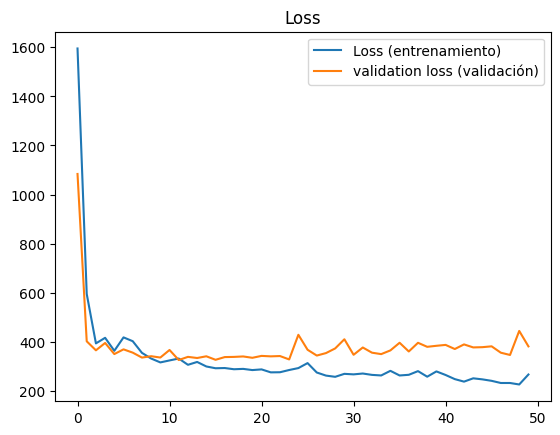

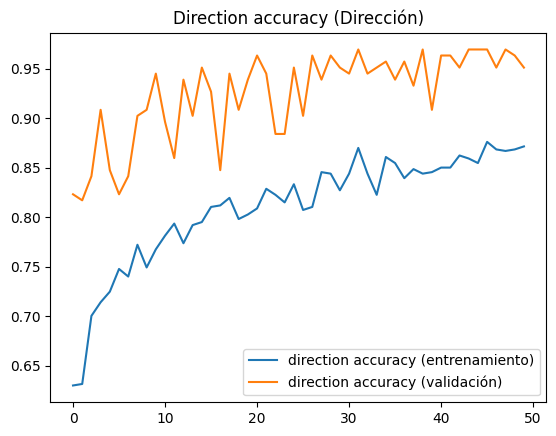

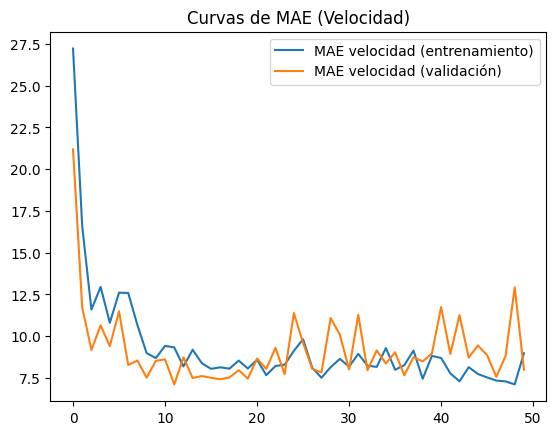

In [ ]:
import matplotlib.pyplot as plt

# Pérdida
plt.plot(history.history['loss'], label='Loss (entrenamiento)')
plt.plot(history.history['val_loss'], label='validation loss (validación)')
plt.legend()
plt.title('Loss')
plt.show()

# Exactitud de dirección
plt.plot(history.history['direction_accuracy'], label='direction accuracy (entrenamiento)')
plt.plot(history.history['val_direction_accuracy'], label='direction accuracy (validación)')
plt.legend()
plt.title('Direction accuracy (Dirección)')
plt.show()

# Error absoluto de velocidad
plt.plot(history.history['speed_mae'], label='MAE velocidad (entrenamiento)')
plt.plot(history.history['val_speed_mae'], label='MAE velocidad (validación)')
plt.legend()
plt.title('Curvas de MAE (Velocidad)')
plt.show()
